# Models Fusion

## Set up

###  Install required packages.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 75.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 36.5 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-5968mvmd
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-5968mvmd
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6173d6e7bfb0192c39e442b6cf4744cbf531a5fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1234822 sha256=83979e8c356dc30d37ccffeda239528536bc7c56327e686b642cdaea42f7db67
  Stored in directory: /tmp/pip-ephem-wheel-cache-tngya

### Unzip Data and Utils

In [2]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


In [3]:
!unzip "data.zip" -d '.'

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C05

### Import and Var

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [3]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [4]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [5]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

### Split Train

In [6]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

## Individual Model

In [7]:
# for txn static, bytecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for source code
from sklearn.linear_model import LogisticRegression

# tuning
import optuna
from sklearn.metrics import f1_score

### Txn Static Feature Model

#### Base

In [8]:
df = load_feature('transaction_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
txn_train_idx = [idx for idx in train_idx if idx in df.index]
txn_test_idx = [idx for idx in test_idx if idx in df.index]

txn_X_train = df.loc[txn_train_idx]
txn_X_test = df.loc[txn_test_idx]
txn_y_train = y_train.loc[txn_train_idx]
txn_y_test = y_test.loc[txn_test_idx]

In [9]:
txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



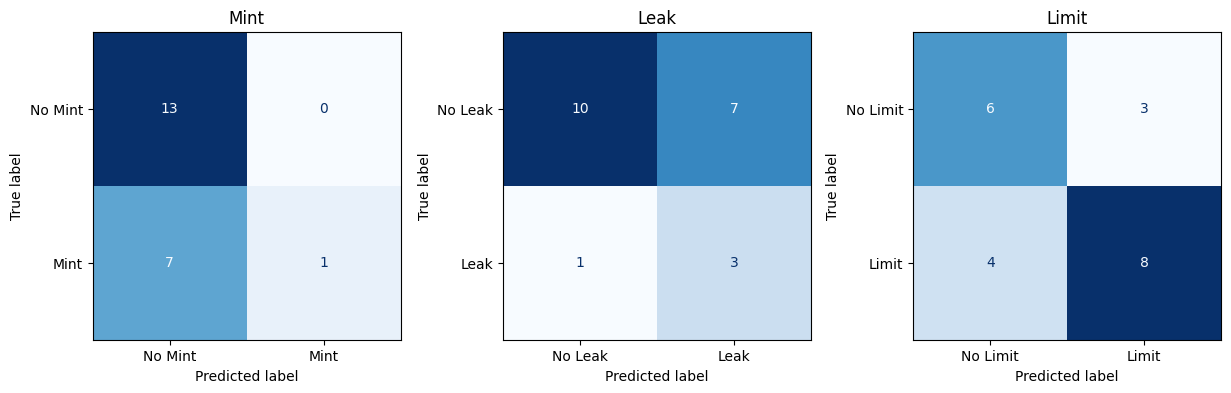

In [10]:
y_pred = txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

#### Tuning

In [11]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(txn_X_train, txn_y_train)
    y_pred = clf.predict(txn_X_test)
    return f1_score(txn_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 21:39:13,266] A new study created in memory with name: no-name-1aedd67a-b3d9-4414-89ac-92b46a3941aa
[I 2025-07-28 21:39:13,826] Trial 0 finished with value: 0.441407867494824 and parameters: {'n_estimators': 124, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 21:39:14,759] Trial 1 finished with value: 0.441407867494824 and parameters: {'n_estimators': 208, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 21:39:15,503] Trial 2 finished with value: 0.441407867494824 and parameters: {'n_estimators': 167, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 21:39:16,170] Trial 3 finished with value: 0.441407867494824 and parameters: {'n_estimators': 145, 'max_depth': 21, 'min_sam

Best Params: {'n_estimators': 186, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Score: 0.4488152749022314


##### Evaluation

In [12]:
tuned_txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_txn_model.fit(txn_X_train, txn_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=24,
                                                       min_samples_split=3,
                                                       n_estimators=186,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



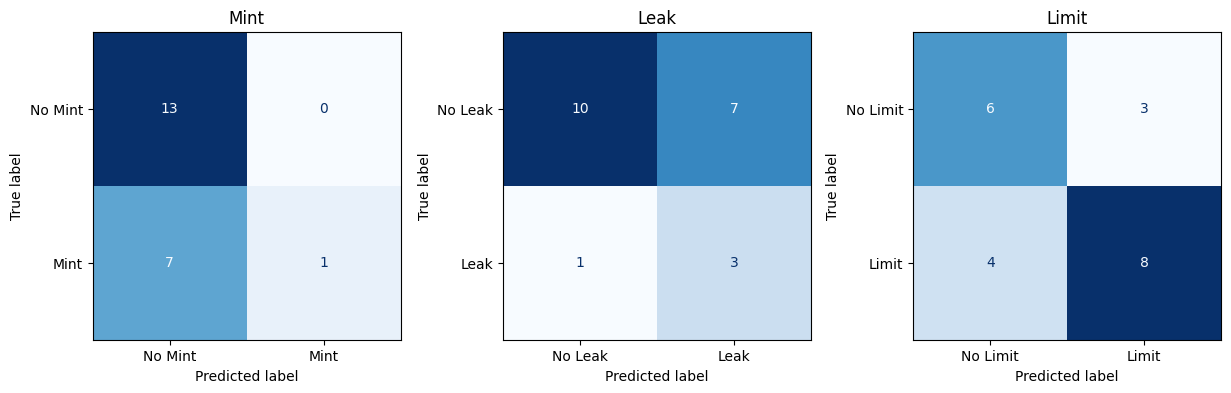

In [13]:
y_pred = tuned_txn_model.predict(txn_X_test)
plot_confusion_matrix(txn_y_test, y_pred)

### Bytecode Static Feature Model

#### Base

In [14]:
df = load_feature('bytecode_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
byte_train_idx = [idx for idx in train_idx if idx in df.index]
byte_test_idx = [idx for idx in test_idx if idx in df.index]

byte_X_train = df.loc[byte_train_idx]
byte_X_test = df.loc[byte_test_idx]
byte_y_train = y_train.loc[byte_train_idx]
byte_y_test = y_test.loc[byte_test_idx]

In [15]:
byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.79      0.40      0.51        24
weighted avg       0.76      0.46      0.55        24
 samples avg       0.37      0.36      0.35        24



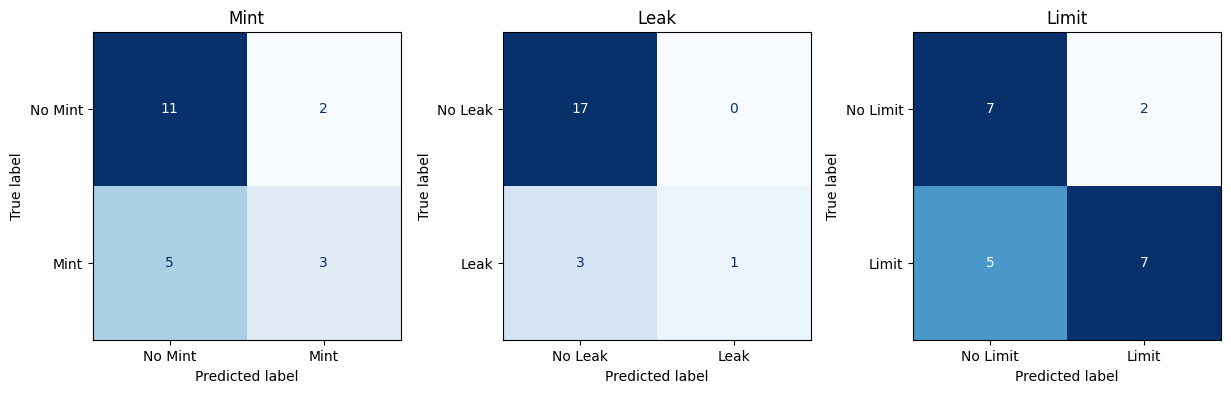

In [16]:
y_pred = byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

#### Tuning

In [17]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(byte_X_train, byte_y_train)
    y_pred = clf.predict(byte_X_test)
    return f1_score(byte_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 21:40:05,769] A new study created in memory with name: no-name-5482c3e2-8196-4d60-bc72-eb0e4bcbef9c
[I 2025-07-28 21:40:06,610] Trial 0 finished with value: 0.5760683760683761 and parameters: {'n_estimators': 171, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.5760683760683761.
[I 2025-07-28 21:40:07,448] Trial 1 finished with value: 0.37606837606837606 and parameters: {'n_estimators': 164, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5760683760683761.
[I 2025-07-28 21:40:08,444] Trial 2 finished with value: 0.5760683760683761 and parameters: {'n_estimators': 212, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.5760683760683761.
[I 2025-07-28 21:40:09,469] Trial 3 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 204, 'max_depth': 23, 

Best Params: {'n_estimators': 117, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}
Best Score: 0.6126984126984127


##### Evaluation

In [18]:
tuned_byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_byte_model.fit(byte_X_train, byte_y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=30,
                                                       max_features='log2',
                                                       min_samples_leaf=4,
                                                       min_samples_split=4,
                                                       n_estimators=117,
                                                       random_state=42))

              precision    recall  f1-score   support

        Mint       0.67      0.50      0.57         8
        Leak       1.00      0.50      0.67         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.75      0.50      0.60        24
   macro avg       0.81      0.50      0.61        24
weighted avg       0.76      0.50      0.60        24
 samples avg       0.41      0.40      0.40        24



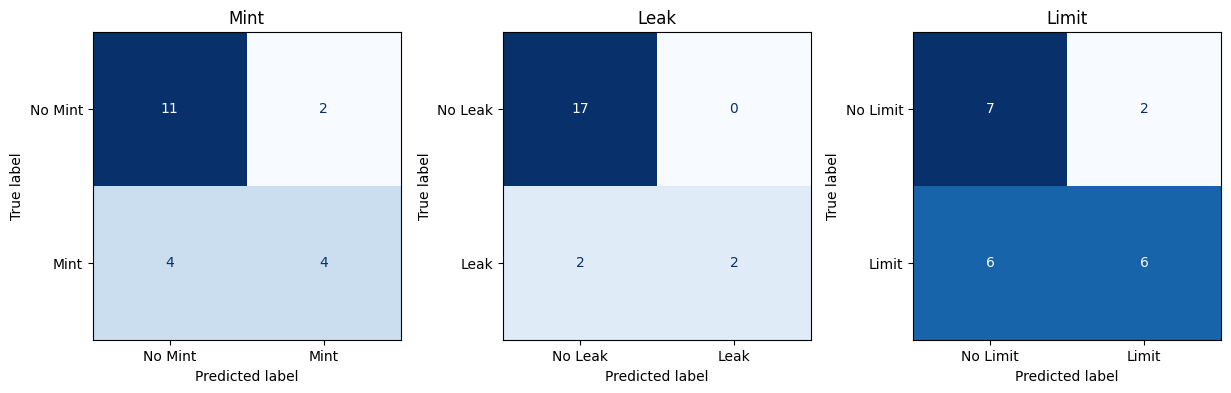

In [19]:
y_pred = tuned_byte_model.predict(byte_X_test)
plot_confusion_matrix(byte_y_test, y_pred)

### Source Code Static Feature Model

#### Base

In [20]:
df = load_feature('tf_idf.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
source_train_idx = [idx for idx in train_idx if idx in df.index]
source_test_idx = [idx for idx in test_idx if idx in df.index]

source_X_train = df.loc[source_train_idx]
source_X_test = df.loc[source_test_idx]
source_y_train = y_train.loc[source_train_idx]
source_y_test = y_test.loc[source_test_idx]

In [21]:
source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42))
source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.86      0.63         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.62      0.59      0.60        22
   macro avg       0.75      0.55      0.55        22
weighted avg       0.72      0.59      0.59        22
 samples avg       0.50      0.43      0.44        22



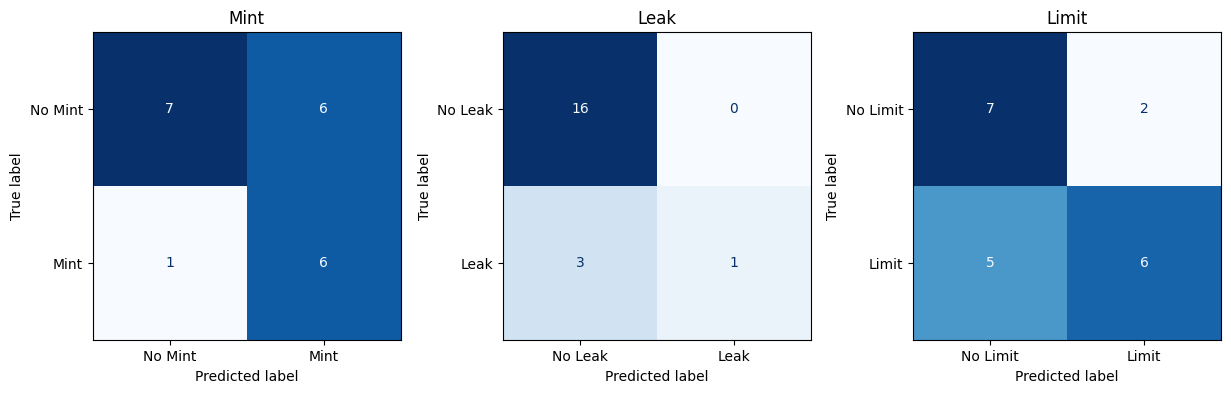

In [22]:
y_pred = source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

#### Tuning

In [23]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-3, 10, log=True),  # regularization strength
        "solver": trial.suggest_categorical(
            "solver", ["liblinear", "saga"]  # both support l1 and l2
        ),
        "max_iter": 1000
    }

    clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **params))
    clf.fit(source_X_train, source_y_train)
    y_pred = clf.predict(source_X_test)
    return f1_score(source_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 21:41:21,786] A new study created in memory with name: no-name-b626be27-65ae-42f6-b21a-8b83e4bda7ac
[I 2025-07-28 21:41:22,034] Trial 0 finished with value: 0.5333333333333333 and parameters: {'penalty': 'l2', 'C': 0.4643128632256087, 'solver': 'saga'}. Best is trial 0 with value: 0.5333333333333333.
[I 2025-07-28 21:41:22,114] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.04254161449898844, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5333333333333333.
[I 2025-07-28 21:41:22,190] Trial 2 finished with value: 0.5238095238095238 and parameters: {'penalty': 'l2', 'C': 0.47500802958624905, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5333333333333333.
[I 2025-07-28 21:41:22,271] Trial 3 finished with value: 0.1111111111111111 and parameters: {'penalty': 'l1', 'C': 0.08731101903516479, 'solver': 'saga'}. Best is trial 0 with value: 0.5333333333333333.
[I 2025-07-28 21:41:22,348] Trial 4 finished with value: 0.5238095238095238 and 

Best Params: {'penalty': 'l2', 'C': 3.7245688482443793, 'solver': 'saga'}
Best Score: 0.6295739348370927


##### Evaluation

In [24]:
tuned_source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **study.best_params))
tuned_source_model.fit(source_X_train, source_y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=3.7245688482443793,
                                                   class_weight='balanced',
                                                   random_state=42,
                                                   solver='saga'))

              precision    recall  f1-score   support

        Mint       0.86      0.86      0.86         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.81      0.59      0.68        22
   macro avg       0.87      0.55      0.63        22
weighted avg       0.83      0.59      0.66        22
 samples avg       0.53      0.43      0.46        22



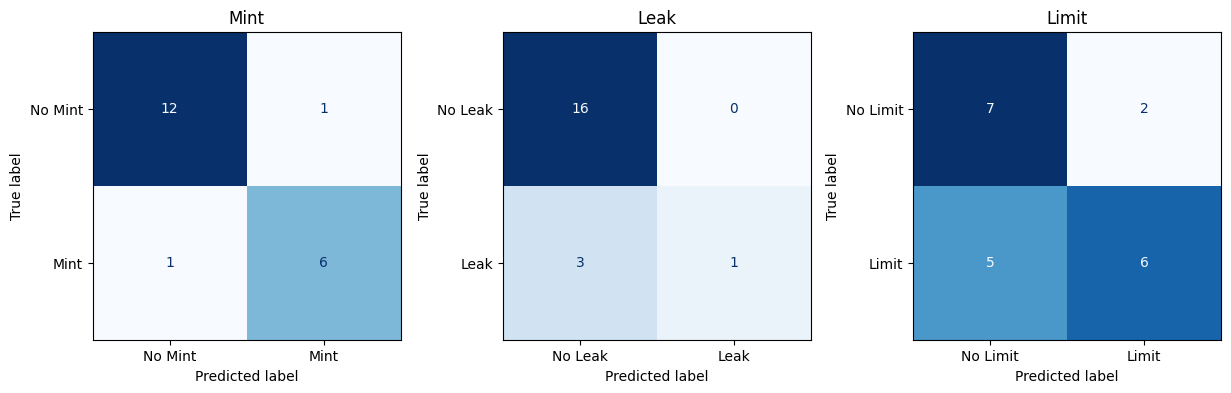

In [25]:
y_pred = tuned_source_model.predict(source_X_test)
plot_confusion_matrix(source_y_test, y_pred)

### Transaction Time Series

#### import lib

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

#### load data

In [27]:
seq_len = 500
feature_dim = 5

ts_X_train, ts_X_test, ts_y_train, ts_y_test, ts_test_idx  = [], [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("value", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0))
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        ts_X_train.append(seq)
        ts_y_train.append(y.loc[addr].tolist())
    elif addr in test_idx:
        ts_X_test.append(seq)
        ts_y_test.append(y.loc[addr].tolist())
        ts_test_idx.append(addr)

100%|██████████| 69/69 [00:02<00:00, 26.44it/s]


In [28]:
ts_X_train = np.array(ts_X_train)
ts_X_test = np.array(ts_X_test)
ts_y_train = np.array(ts_y_train)
ts_y_test = np.array(ts_y_test)

#### tuning

In [29]:
epochs = 20

In [30]:
def build_gru_model(input_shape, units, lr, output=len(label_cols)):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        GRU(units),
        Dense(output, activation='sigmoid')  # for multilabel
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy())
    return model

In [31]:
def objective(trial):
    units = trial.suggest_int("units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=units, lr=lr)
    model.fit(ts_X_train, ts_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred = model.predict(ts_X_test)
    thresholds, _ = tune_thresholds(ts_y_test, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(ts_y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 21:43:00,488] A new study created in memory with name: no-name-cc937786-a11b-4941-9fb0-18d0a4ba1179


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.7
Label 1: Best threshold = 0.03, Best f1 = 0.4444444444444444


[I 2025-07-28 21:43:26,714] Trial 0 finished with value: 0.6530864197530865 and parameters: {'units': 95, 'lr': 0.002755763166022638, 'batch_size': 32}. Best is trial 0 with value: 0.6530864197530865.


Label 2: Best threshold = 0.06, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Label 0: Best threshold = 0.34, Best f1 = 0.56
Label 1: Best threshold = 0.34, Best f1 = 0.4444444444444444


[I 2025-07-28 21:43:43,594] Trial 1 finished with value: 0.6205291005291005 and parameters: {'units': 102, 'lr': 0.0008227792208188525, 'batch_size': 64}. Best is trial 0 with value: 0.6530864197530865.


Label 2: Best threshold = 0.45, Best f1 = 0.8571428571428571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Label 0: Best threshold = 0.0, Best f1 = 0.5517241379310345
Label 1: Best threshold = 0.48, Best f1 = 0.4


[I 2025-07-28 21:44:11,832] Trial 2 finished with value: 0.5672413793103449 and parameters: {'units': 125, 'lr': 0.00016764907685771422, 'batch_size': 32}. Best is trial 0 with value: 0.6530864197530865.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Label 0: Best threshold = 0.1, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.09, Best f1 = 0.47058823529411764


[I 2025-07-28 21:44:29,729] Trial 3 finished with value: 0.6813382695735637 and parameters: {'units': 62, 'lr': 0.007413173490999357, 'batch_size': 16}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.08, Best f1 = 0.8461538461538461


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.41000000000000003, Best f1 = 0.42857142857142855


[I 2025-07-28 21:44:44,801] Trial 4 finished with value: 0.6568863235529903 and parameters: {'units': 78, 'lr': 0.009586935548192052, 'batch_size': 64}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.07, Best f1 = 0.8148148148148148


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Label 0: Best threshold = 0.0, Best f1 = 0.5517241379310345
Label 1: Best threshold = 0.46, Best f1 = 0.4444444444444444


[I 2025-07-28 21:45:14,968] Trial 5 finished with value: 0.5987228607918264 and parameters: {'units': 122, 'lr': 0.00015291031767505954, 'batch_size': 32}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.49, Best f1 = 0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Label 0: Best threshold = 0.31, Best f1 = 0.6
Label 1: Best threshold = 0.24, Best f1 = 0.42857142857142855


[I 2025-07-28 21:45:32,790] Trial 6 finished with value: 0.6144620811287478 and parameters: {'units': 77, 'lr': 0.0006470230501475374, 'batch_size': 16}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.38, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
Label 0: Best threshold = 0.25, Best f1 = 0.7
Label 1: Best threshold = 0.46, Best f1 = 0.42857142857142855


[I 2025-07-28 21:45:55,932] Trial 7 finished with value: 0.6477954144620811 and parameters: {'units': 86, 'lr': 0.0036836721994411505, 'batch_size': 32}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.02, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Label 0: Best threshold = 0.0, Best f1 = 0.5517241379310345
Label 1: Best threshold = 0.49, Best f1 = 0.42105263157894735


[I 2025-07-28 21:46:09,390] Trial 8 finished with value: 0.5742589231699939 and parameters: {'units': 39, 'lr': 0.00010800759379060941, 'batch_size': 64}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Label 0: Best threshold = 0.45, Best f1 = 0.5555555555555556
Label 1: Best threshold = 0.13, Best f1 = 0.42857142857142855


[I 2025-07-28 21:46:26,421] Trial 9 finished with value: 0.5899470899470899 and parameters: {'units': 55, 'lr': 0.000996251839108967, 'batch_size': 16}. Best is trial 3 with value: 0.6813382695735637.


Label 2: Best threshold = 0.33, Best f1 = 0.7857142857142857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Label 0: Best threshold = 0.31, Best f1 = 0.7619047619047619


[I 2025-07-28 21:46:42,675] Trial 10 finished with value: 0.6841676841676841 and parameters: {'units': 61, 'lr': 0.00938878087529366, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 1: Best threshold = 0.06, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.09, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Label 0: Best threshold = 0.33, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.02, Best f1 = 0.4444444444444444


[I 2025-07-28 21:46:58,684] Trial 11 finished with value: 0.6405723905723906 and parameters: {'units': 56, 'lr': 0.009966154284804046, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.12, Best f1 = 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Label 0: Best threshold = 0.27, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.32, Best f1 = 0.42857142857142855
Label 2: Best threshold = 0.27, Best f1 = 0.7741935483870968


[I 2025-07-28 21:47:15,068] Trial 12 finished with value: 0.6433459014104176 and parameters: {'units': 60, 'lr': 0.0036128480434511785, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Label 0: Best threshold = 0.09, Best f1 = 0.631578947368421
Label 1: Best threshold = 0.05, Best f1 = 0.4444444444444444


[I 2025-07-28 21:47:29,320] Trial 13 finished with value: 0.6407257459889039 and parameters: {'units': 35, 'lr': 0.00541771236440814, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.05, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Label 0: Best threshold = 0.35000000000000003, Best f1 = 0.7
Label 1: Best threshold = 0.44, Best f1 = 0.42857142857142855
Label 2: Best threshold = 0.04, Best f1 = 0.8148148148148148


[I 2025-07-28 21:47:45,446] Trial 14 finished with value: 0.6477954144620811 and parameters: {'units': 67, 'lr': 0.002214812962128103, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Label 0: Best threshold = 0.12, Best f1 = 0.5714285714285714
Label 1: Best threshold = 0.04, Best f1 = 0.4444444444444444


[I 2025-07-28 21:48:01,012] Trial 15 finished with value: 0.6102292768959435 and parameters: {'units': 47, 'lr': 0.0016806184053852022, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.33, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Label 0: Best threshold = 0.2, Best f1 = 0.6153846153846154
Label 1: Best threshold = 0.12, Best f1 = 0.4444444444444444


[I 2025-07-28 21:48:17,831] Trial 16 finished with value: 0.6248812915479581 and parameters: {'units': 68, 'lr': 0.005993388460775222, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.29, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Label 0: Best threshold = 0.07, Best f1 = 0.6956521739130435
Label 1: Best threshold = 0.09, Best f1 = 0.47058823529411764


[I 2025-07-28 21:48:34,518] Trial 17 finished with value: 0.6603517413406587 and parameters: {'units': 45, 'lr': 0.0058912662373272326, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.1, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Label 0: Best threshold = 0.0, Best f1 = 0.5517241379310345


[I 2025-07-28 21:48:54,487] Trial 18 finished with value: 0.5983701271057593 and parameters: {'units': 68, 'lr': 0.0003418197195778481, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 1: Best threshold = 0.45, Best f1 = 0.42857142857142855
Label 2: Best threshold = 0.49, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
Label 0: Best threshold = 0.2, Best f1 = 0.6
Label 1: Best threshold = 0.2, Best f1 = 0.42857142857142855


[I 2025-07-28 21:49:13,013] Trial 19 finished with value: 0.6095238095238095 and parameters: {'units': 102, 'lr': 0.0014057288425889402, 'batch_size': 64}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.22, Best f1 = 0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Label 0: Best threshold = 0.45, Best f1 = 0.5555555555555556
Label 1: Best threshold = 0.26, Best f1 = 0.4444444444444444


[I 2025-07-28 21:49:38,525] Trial 20 finished with value: 0.6049382716049383 and parameters: {'units': 91, 'lr': 0.000378925381493524, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.42, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Label 0: Best threshold = 0.09, Best f1 = 0.7
Label 1: Best threshold = 0.09, Best f1 = 0.42857142857142855


[I 2025-07-28 21:49:53,078] Trial 21 finished with value: 0.6582417582417582 and parameters: {'units': 45, 'lr': 0.0060747701878243595, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Label 0: Best threshold = 0.36, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.09, Best f1 = 0.47058823529411764


[I 2025-07-28 21:50:09,572] Trial 22 finished with value: 0.6708919257938866 and parameters: {'units': 47, 'lr': 0.006862943923538754, 'batch_size': 16}. Best is trial 10 with value: 0.6841676841676841.


Label 2: Best threshold = 0.17, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.7619047619047619


[I 2025-07-28 21:50:25,581] Trial 23 finished with value: 0.6928822811175753 and parameters: {'units': 60, 'lr': 0.009944023926032303, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 1: Best threshold = 0.07, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.34, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.15, Best f1 = 0.4444444444444444


[I 2025-07-28 21:50:41,817] Trial 24 finished with value: 0.673721340388007 and parameters: {'units': 63, 'lr': 0.004340927625938929, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.26, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Label 0: Best threshold = 0.26, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.06, Best f1 = 0.47058823529411764


[I 2025-07-28 21:50:57,881] Trial 25 finished with value: 0.6928822811175753 and parameters: {'units': 54, 'lr': 0.009346370756828636, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.31, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Label 0: Best threshold = 0.16, Best f1 = 0.6
Label 1: Best threshold = 0.12, Best f1 = 0.42857142857142855


[I 2025-07-28 21:51:12,810] Trial 26 finished with value: 0.6144620811287478 and parameters: {'units': 53, 'lr': 0.00958759590013752, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.11, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Label 0: Best threshold = 0.38, Best f1 = 0.7
Label 1: Best threshold = 0.18, Best f1 = 0.42857142857142855


[I 2025-07-28 21:51:30,382] Trial 27 finished with value: 0.6582417582417582 and parameters: {'units': 70, 'lr': 0.0024335129264564117, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.06, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Label 0: Best threshold = 0.23, Best f1 = 0.6153846153846154
Label 1: Best threshold = 0.44, Best f1 = 0.42857142857142855


[I 2025-07-28 21:51:46,258] Trial 28 finished with value: 0.6195902862569529 and parameters: {'units': 78, 'lr': 0.00433683092399391, 'batch_size': 64}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.06, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Label 0: Best threshold = 0.1, Best f1 = 0.5714285714285714
Label 1: Best threshold = 0.17, Best f1 = 0.42857142857142855


[I 2025-07-28 21:52:04,897] Trial 29 finished with value: 0.6049382716049383 and parameters: {'units': 52, 'lr': 0.002893995354210348, 'batch_size': 32}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.26, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Label 0: Best threshold = 0.31, Best f1 = 0.7
Label 1: Best threshold = 0.38, Best f1 = 0.42857142857142855


[I 2025-07-28 21:52:23,565] Trial 30 finished with value: 0.6477954144620811 and parameters: {'units': 34, 'lr': 0.007661724835997213, 'batch_size': 32}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.05, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Label 0: Best threshold = 0.18, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.13, Best f1 = 0.47058823529411764


[I 2025-07-28 21:52:46,150] Trial 31 finished with value: 0.6708919257938866 and parameters: {'units': 61, 'lr': 0.007879744900004412, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.23, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Label 0: Best threshold = 0.43, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.07, Best f1 = 0.47058823529411764


[I 2025-07-28 21:53:05,086] Trial 32 finished with value: 0.6928822811175753 and parameters: {'units': 60, 'lr': 0.004742535170726801, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.15, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Label 0: Best threshold = 0.22, Best f1 = 0.6956521739130435
Label 1: Best threshold = 0.08, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.38, Best f1 = 0.8275862068965517


[I 2025-07-28 21:53:20,451] Trial 33 finished with value: 0.6558942750846799 and parameters: {'units': 40, 'lr': 0.004788600334464984, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Label 0: Best threshold = 0.32, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.1, Best f1 = 0.47058823529411764


[I 2025-07-28 21:53:37,026] Trial 34 finished with value: 0.6824359373378982 and parameters: {'units': 72, 'lr': 0.0031523064816435264, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.18, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Label 0: Best threshold = 0.15, Best f1 = 0.56
Label 1: Best threshold = 0.07, Best f1 = 0.4444444444444444


[I 2025-07-28 21:53:56,768] Trial 35 finished with value: 0.6064197530864197 and parameters: {'units': 84, 'lr': 0.007922248376429528, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.26, Best f1 = 0.8148148148148148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Label 0: Best threshold = 0.25, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.17, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.28, Best f1 = 0.8148148148148148

[I 2025-07-28 21:54:18,286] Trial 36 finished with value: 0.6708919257938866 and parameters: {'units': 105, 'lr': 0.009439858065677237, 'batch_size': 64}. Best is trial 23 with value: 0.6928822811175753.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Label 0: Best threshold = 0.25, Best f1 = 0.56
Label 1: Best threshold = 0.25, Best f1 = 0.42857142857142855
Label 2: Best threshold = 0.3, Best f1 = 0.8148148148148148


[I 2025-07-28 21:54:38,272] Trial 37 finished with value: 0.6011287477954145 and parameters: {'units': 74, 'lr': 0.0019520288307890536, 'batch_size': 32}. Best is trial 23 with value: 0.6928822811175753.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Label 0: Best threshold = 0.41000000000000003, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.08, Best f1 = 0.4444444444444444


[I 2025-07-28 21:54:54,036] Trial 38 finished with value: 0.6601809182454343 and parameters: {'units': 59, 'lr': 0.0047796250922676085, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.29, Best f1 = 0.7741935483870968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.6
Label 1: Best threshold = 0.25, Best f1 = 0.42857142857142855


[I 2025-07-28 21:55:10,669] Trial 39 finished with value: 0.6095238095238095 and parameters: {'units': 64, 'lr': 0.0006600601516778201, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.26, Best f1 = 0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Label 0: Best threshold = 0.19, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.45, Best f1 = 0.42857142857142855


[I 2025-07-28 21:55:23,969] Trial 40 finished with value: 0.6673326673326674 and parameters: {'units': 50, 'lr': 0.007205697748007337, 'batch_size': 64}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.36, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Label 0: Best threshold = 0.44, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.17, Best f1 = 0.42857142857142855

[I 2025-07-28 21:55:39,919] Trial 41 finished with value: 0.6726874657909141 and parameters: {'units': 73, 'lr': 0.0032079721436816073, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.



Label 2: Best threshold = 0.06, Best f1 = 0.8275862068965517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Label 0: Best threshold = 0.34, Best f1 = 0.7619047619047619


[I 2025-07-28 21:55:56,867] Trial 42 finished with value: 0.6841676841676841 and parameters: {'units': 83, 'lr': 0.0037859777554269496, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 1: Best threshold = 0.08, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.1, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Label 0: Best threshold = 0.09, Best f1 = 0.6666666666666666
Label 1: Best threshold = 0.11, Best f1 = 0.42857142857142855


[I 2025-07-28 21:56:14,954] Trial 43 finished with value: 0.647130647130647 and parameters: {'units': 86, 'lr': 0.0037923046630317157, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.12, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Label 0: Best threshold = 0.11, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.07, Best f1 = 0.47058823529411764


[I 2025-07-28 21:56:39,662] Trial 44 finished with value: 0.6813382695735637 and parameters: {'units': 97, 'lr': 0.009882703440365766, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.34, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Label 0: Best threshold = 0.44, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.08, Best f1 = 0.47058823529411764


[I 2025-07-28 21:56:58,176] Trial 45 finished with value: 0.6573515036513139 and parameters: {'units': 82, 'lr': 0.005209892412808984, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.24, Best f1 = 0.7741935483870968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.09, Best f1 = 0.47058823529411764


[I 2025-07-28 21:57:30,057] Trial 46 finished with value: 0.6813382695735637 and parameters: {'units': 116, 'lr': 0.006479798599906091, 'batch_size': 32}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.27, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Label 0: Best threshold = 0.05, Best f1 = 0.7619047619047619


[I 2025-07-28 21:57:46,961] Trial 47 finished with value: 0.6928822811175753 and parameters: {'units': 55, 'lr': 0.007852635834656877, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 1: Best threshold = 0.06, Best f1 = 0.47058823529411764
Label 2: Best threshold = 0.08, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Label 0: Best threshold = 0.09, Best f1 = 0.7272727272727273
Label 1: Best threshold = 0.07, Best f1 = 0.47058823529411764


[I 2025-07-28 21:58:06,837] Trial 48 finished with value: 0.6813382695735637 and parameters: {'units': 57, 'lr': 0.008343139125337344, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.12, Best f1 = 0.8461538461538461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Label 0: Best threshold = 0.41000000000000003, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.14, Best f1 = 0.42857142857142855


[I 2025-07-28 21:58:22,515] Trial 49 finished with value: 0.6788766788766788 and parameters: {'units': 40, 'lr': 0.006411239652456656, 'batch_size': 16}. Best is trial 23 with value: 0.6928822811175753.


Label 2: Best threshold = 0.22, Best f1 = 0.8461538461538461
Best Params: {'units': 60, 'lr': 0.009944023926032303, 'batch_size': 16}
Best Score: 0.6928822811175753


#### final

In [32]:
tuned_gru_model = build_gru_model(input_shape=(ts_X_train.shape[1], ts_X_train.shape[2]), units=study.best_params['units'], lr=study.best_params['lr'])
tuned_gru_model.fit(ts_X_train, ts_y_train, epochs=epochs, batch_size=study.best_params['batch_size'], verbose=2)

Epoch 1/20
3/3 - 2s - 817ms/step - loss: 0.6727
Epoch 2/20
3/3 - 1s - 210ms/step - loss: 0.5826
Epoch 3/20
3/3 - 1s - 227ms/step - loss: 0.5374
Epoch 4/20
3/3 - 1s - 274ms/step - loss: 0.5248
Epoch 5/20
3/3 - 1s - 430ms/step - loss: 0.5141
Epoch 6/20
3/3 - 1s - 189ms/step - loss: 0.4949
Epoch 7/20
3/3 - 1s - 180ms/step - loss: 0.4904
Epoch 8/20
3/3 - 1s - 191ms/step - loss: 0.5020
Epoch 9/20
3/3 - 1s - 180ms/step - loss: 0.5098
Epoch 10/20
3/3 - 1s - 184ms/step - loss: 0.4709
Epoch 11/20
3/3 - 1s - 215ms/step - loss: 0.4919
Epoch 12/20
3/3 - 1s - 180ms/step - loss: 0.4878
Epoch 13/20
3/3 - 1s - 187ms/step - loss: 0.4797
Epoch 14/20
3/3 - 1s - 180ms/step - loss: 0.4717
Epoch 15/20
3/3 - 1s - 188ms/step - loss: 0.4597
Epoch 16/20
3/3 - 1s - 180ms/step - loss: 0.4483
Epoch 17/20
3/3 - 1s - 214ms/step - loss: 0.4637
Epoch 18/20
3/3 - 1s - 199ms/step - loss: 0.4448
Epoch 19/20
3/3 - 1s - 183ms/step - loss: 0.4416
Epoch 20/20
3/3 - 1s - 212ms/step - loss: 0.4313


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Label 0: Best threshold = 0.18, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.07, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.23, Best f1 = 0.8461538461538461
              precision    recall  f1-score   support

        Mint       0.62      1.00      0.76         8
        Leak       0.29      1.00      0.44         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.56      0.96      0.71        24
   macro avg       0.56      0.97      0.68        24
weighted avg       0.65      0.96      0.75        24
 samples avg       0.46      0.64      0.51        24



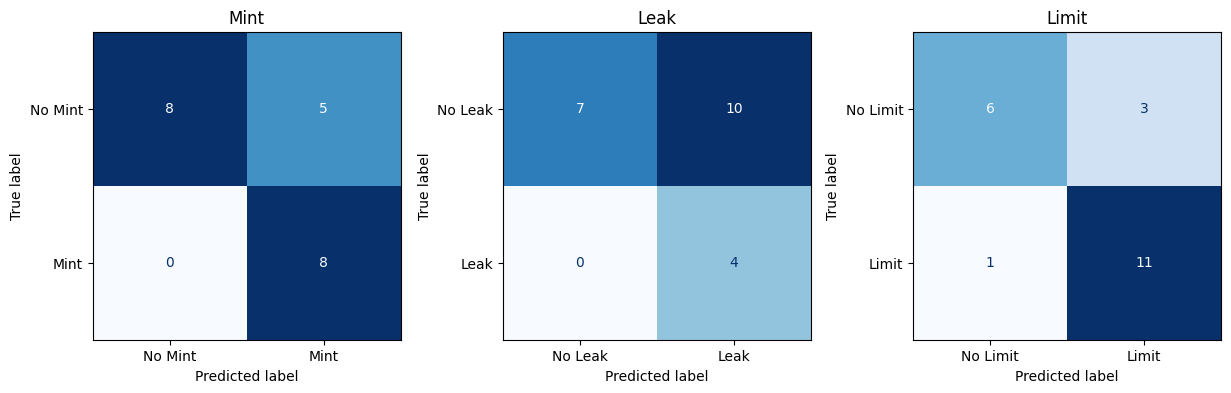

In [33]:
y_pred = tuned_gru_model.predict(ts_X_test)
thresholds, _ = tune_thresholds(ts_y_test, y_pred)

y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(ts_y_test, y_pred)

### Graph

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

##### Load Data

In [35]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [36]:
train_dataset, test_dataset = [], []
txn_graph_y_train, txn_graph_y_test = [], []
txn_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        txn_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        txn_graph_y_test.append(y.loc[address])
        txn_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [37]:
len(train_dataset), len(test_dataset)

(26, 11)

In [38]:
txn_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
txn_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [39]:
epochs = 30

In [40]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in txn_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in txn_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 21:58:41,357] A new study created in memory with name: no-name-1c46d0f9-fcda-474c-8324-43017e3183ea


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:58:55,414] Trial 0 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 195, 'lr': 0.0010946282556824746, 'dropout': 0.26599647689148437}. Best is trial 0 with value: 0.1818181818181818.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 21:59:01,359] Trial 1 finished with value: 0.0 and parameters: {'hidden_dim': 120, 'lr': 0.008050521400336784, 'dropout': 0.6242947979795371}. Best is trial 0 with value: 0.1818181818181818.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:07,833] Trial 2 finished with value: 0.0 and parameters: {'hidden_dim': 112, 'lr': 3.832888250278925e-05, 'dropout': 0.6402490403956136}. Best is trial 0 with value: 0.1818181818181818.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-28 21:59:10,674] Trial 3 finished with value: 0.27777777777777773 and parameters: {'hidden_dim': 33, 'lr': 8.270864050262973e-05, 'dropout': 0.3868349080411583}. Best is trial 3 with value: 0.27777777777777773.


Label 0: Best threshold = 0.01, Best f1 = 0.5


[I 2025-07-28 21:59:15,803] Trial 4 finished with value: 0.24074074074074073 and parameters: {'hidden_dim': 78, 'lr': 0.0006766265598178118, 'dropout': 0.1919262662164939}. Best is trial 3 with value: 0.27777777777777773.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:30,942] Trial 5 finished with value: 0.2857142857142857 and parameters: {'hidden_dim': 246, 'lr': 0.007498940161644418, 'dropout': 0.07429712438144076}. Best is trial 5 with value: 0.2857142857142857.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:37,382] Trial 6 finished with value: 0.0 and parameters: {'hidden_dim': 126, 'lr': 0.0055440209544987094, 'dropout': 0.5313077600819994}. Best is trial 5 with value: 0.2857142857142857.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:41,020] Trial 7 finished with value: 0.0 and parameters: {'hidden_dim': 63, 'lr': 5.757973580412007e-06, 'dropout': 0.3822452763380777}. Best is trial 5 with value: 0.2857142857142857.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:45,974] Trial 8 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 83, 'lr': 2.200028169665204e-05, 'dropout': 0.47399764469237793}. Best is trial 5 with value: 0.2857142857142857.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 21:59:54,353] Trial 9 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 124, 'lr': 0.0002517610280955018, 'dropout': 0.2185579118460196}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:00:04,754] Trial 10 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 173, 'lr': 1.0676397727358398e-06, 'dropout': 0.7854597716291679}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:00:23,471] Trial 11 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 255, 'lr': 0.0005387734557729913, 'dropout': 0.021835331478024494}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:00:43,215] Trial 12 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 234, 'lr': 0.0002716711299293819, 'dropout': 0.06971938594724167}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:00:52,861] Trial 13 finished with value: 0.2857142857142857 and parameters: {'hidden_dim': 163, 'lr': 0.0025510865297819155, 'dropout': 0.16191458626626826}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 22:01:08,138] Trial 14 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 211, 'lr': 0.00019766207822654084, 'dropout': 0.281953496589878}. Best is trial 9 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:01:18,322] Trial 15 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 154, 'lr': 0.002234577518238126, 'dropout': 0.12202967552393597}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:01:28,474] Trial 16 finished with value: 0.0 and parameters: {'hidden_dim': 196, 'lr': 8.36271176790699e-06, 'dropout': 0.2827183523865141}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:01:39,431] Trial 17 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 140, 'lr': 8.926170562821687e-05, 'dropout': 0.21172565559790477}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:01:45,208] Trial 18 finished with value: 0.2857142857142857 and parameters: {'hidden_dim': 98, 'lr': 0.0039599354205612615, 'dropout': 0.038264038967297576}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:03,511] Trial 19 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 226, 'lr': 0.0014579012280395882, 'dropout': 0.11465073324866695}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:14,212] Trial 20 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 179, 'lr': 0.0002883923125665038, 'dropout': 0.34822112653481446}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:22,024] Trial 21 finished with value: 0.29523809523809524 and parameters: {'hidden_dim': 155, 'lr': 0.003094059997064136, 'dropout': 0.15533381433007742}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:30,047] Trial 22 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 147, 'lr': 0.008555324650437613, 'dropout': 0.00658366928823384}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:33,421] Trial 23 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 52, 'lr': 0.0032689104159678733, 'dropout': 0.12417758407221308}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:02:58,868] Trial 24 finished with value: 0.0 and parameters: {'hidden_dim': 254, 'lr': 0.0007272584401244124, 'dropout': 0.2223614385507511}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:03:06,202] Trial 25 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 100, 'lr': 0.001444910210685189, 'dropout': 0.09718080107639179}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 22:03:17,275] Trial 26 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 190, 'lr': 0.008698558525783225, 'dropout': 0.3223654459709043}. Best is trial 9 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:03:25,434] Trial 27 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 127, 'lr': 0.00016658667604367312, 'dropout': 0.15388023991611732}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:03:46,962] Trial 28 finished with value: 0.0 and parameters: {'hidden_dim': 218, 'lr': 0.0004254910780104858, 'dropout': 0.4411164730563395}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:03,640] Trial 29 finished with value: 0.0 and parameters: {'hidden_dim': 198, 'lr': 0.0011957147942002213, 'dropout': 0.24093488201731605}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:18,868] Trial 30 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 238, 'lr': 0.002267924719629298, 'dropout': 0.07380660352385213}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-28 22:04:27,325] Trial 31 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 161, 'lr': 0.0041035939874183745, 'dropout': 0.19497191740583342}. Best is trial 9 with value: 0.4222222222222222.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:36,117] Trial 32 finished with value: 0.0 and parameters: {'hidden_dim': 137, 'lr': 0.0023414507693831875, 'dropout': 0.15701336400389906}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:45,768] Trial 33 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 164, 'lr': 0.009555006014754135, 'dropout': 0.16415335416340698}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:51,534] Trial 34 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 114, 'lr': 0.005229958750162747, 'dropout': 0.2667093684973764}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:04:57,312] Trial 35 finished with value: 0.0 and parameters: {'hidden_dim': 102, 'lr': 3.700475054424831e-05, 'dropout': 0.0656331449006114}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:05:08,460] Trial 36 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 177, 'lr': 0.0008968669500157447, 'dropout': 0.16654050230420275}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:05:26,279] Trial 37 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 182, 'lr': 0.0008391481226508681, 'dropout': 0.2386095191813571}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:05:37,313] Trial 38 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 206, 'lr': 0.00013326181006311787, 'dropout': 0.33765460295211636}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:05:45,198] Trial 39 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 133, 'lr': 0.0003298213850133903, 'dropout': 0.5933311978203051}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:05:54,062] Trial 40 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 147, 'lr': 0.0009365524671123966, 'dropout': 0.7014023736920012}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:02,598] Trial 41 finished with value: 0.0 and parameters: {'hidden_dim': 119, 'lr': 0.0010535918614212022, 'dropout': 0.7849326861646009}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:13,417] Trial 42 finished with value: 0.0 and parameters: {'hidden_dim': 148, 'lr': 0.0006001179968839111, 'dropout': 0.5342239074974168}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:21,863] Trial 43 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 174, 'lr': 5.660414091659741e-05, 'dropout': 0.41703659022510126}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:28,861] Trial 44 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 129, 'lr': 0.0061564532981185785, 'dropout': 0.7110968975133622}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:34,073] Trial 45 finished with value: 0.0 and parameters: {'hidden_dim': 80, 'lr': 0.0015112342174347921, 'dropout': 0.6799112999140147}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:44,419] Trial 46 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 156, 'lr': 0.0005074291760154058, 'dropout': 0.5141238743755236}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:50,617] Trial 47 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 109, 'lr': 0.005344979471400236, 'dropout': 0.30673022808445694}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:06:56,224] Trial 48 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 90, 'lr': 0.001790440686975551, 'dropout': 0.04406516122446627}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:07:08,807] Trial 49 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 167, 'lr': 0.0009064665476681982, 'dropout': 0.1881789058567368}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:07:26,713] Trial 50 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 243, 'lr': 0.00037039366358407246, 'dropout': 0.3761122932113367}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 22:07:34,730] Trial 51 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 145, 'lr': 0.0038839861080452328, 'dropout': 0.1418031611287278}. Best is trial 9 with value: 0.4222222222222222.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:07:45,657] Trial 52 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 188, 'lr': 0.0029108819205604674, 'dropout': 0.07929569084565391}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:07:54,988] Trial 53 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 153, 'lr': 0.0002117044141415686, 'dropout': 0.18885220622294807}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:04,565] Trial 54 finished with value: 0.32996632996632996 and parameters: {'hidden_dim': 169, 'lr': 0.002540981724271022, 'dropout': 0.1001947681050161}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:16,783] Trial 55 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 180, 'lr': 0.0019548600202371085, 'dropout': 0.0037415008854976423}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:25,451] Trial 56 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 172, 'lr': 0.0059380258766765955, 'dropout': 0.10125382782814794}. Best is trial 9 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.5


[I 2025-07-28 22:08:32,779] Trial 57 finished with value: 0.4305555555555555 and parameters: {'hidden_dim': 139, 'lr': 1.876691544924678e-06, 'dropout': 0.05166917025378401}. Best is trial 57 with value: 0.4305555555555555.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:39,358] Trial 58 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 140, 'lr': 1.3637313298810803e-06, 'dropout': 0.11936542380133475}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:46,489] Trial 59 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 121, 'lr': 1.1667671440635322e-05, 'dropout': 0.04492648751774986}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:08:54,600] Trial 60 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 161, 'lr': 1.6956352938442776e-05, 'dropout': 0.6016986639065285}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:01,960] Trial 61 finished with value: 0.4067460317460318 and parameters: {'hidden_dim': 149, 'lr': 3.30775259554927e-06, 'dropout': 0.03783641369462698}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:09,514] Trial 62 finished with value: 0.3055555555555555 and parameters: {'hidden_dim': 152, 'lr': 2.6465376700654613e-06, 'dropout': 0.08580764864048754}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:16,304] Trial 63 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 148, 'lr': 2.208023318491575e-06, 'dropout': 0.028282097624775543}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:29,481] Trial 64 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 138, 'lr': 4.142612383434177e-06, 'dropout': 0.0891299005949732}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:38,472] Trial 65 finished with value: 0.27619047619047615 and parameters: {'hidden_dim': 171, 'lr': 3.4814500301536664e-06, 'dropout': 0.13249182500613138}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:45,776] Trial 66 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 131, 'lr': 1.0477663082087626e-06, 'dropout': 0.05850452404897338}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:51,977] Trial 67 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 122, 'lr': 1.0574564220974758e-06, 'dropout': 0.056002531953453324}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:09:58,826] Trial 68 finished with value: 0.375 and parameters: {'hidden_dim': 133, 'lr': 1.7912139291744692e-06, 'dropout': 0.020446187712343383}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:04,141] Trial 69 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 109, 'lr': 1.978850716005941e-06, 'dropout': 0.006392793208065713}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 22:10:11,152] Trial 70 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 133, 'lr': 5.3946291324513925e-06, 'dropout': 0.027102936381138126}. Best is trial 57 with value: 0.4305555555555555.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4
Label 2: Best threshold = 0.0, Best f1 = 0.625


[I 2025-07-28 22:10:17,992] Trial 71 finished with value: 0.3416666666666666 and parameters: {'hidden_dim': 143, 'lr': 1.8266830234136836e-06, 'dropout': 0.06278131902512102}. Best is trial 57 with value: 0.4305555555555555.


Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:24,780] Trial 72 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 130, 'lr': 1.6904589420725783e-06, 'dropout': 0.06448973044762164}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:31,484] Trial 73 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 141, 'lr': 2.9580016520946504e-06, 'dropout': 0.0009611088884095148}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:38,829] Trial 74 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 141, 'lr': 1.4203946576022667e-06, 'dropout': 0.02245470206935644}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:44,354] Trial 75 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 115, 'lr': 3.15539909408772e-06, 'dropout': 0.04186116734940862}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:48,832] Trial 76 finished with value: 0.375 and parameters: {'hidden_dim': 69, 'lr': 2.808149320880534e-06, 'dropout': 0.0010335051261120276}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:10:52,623] Trial 77 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 66, 'lr': 2.8585664110627243e-06, 'dropout': 0.03471845937325885}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.6


[I 2025-07-28 22:10:56,060] Trial 78 finished with value: 0.4083333333333334 and parameters: {'hidden_dim': 57, 'lr': 6.207768376641621e-06, 'dropout': 0.006733592586514708}. Best is trial 57 with value: 0.4305555555555555.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:00,849] Trial 79 finished with value: 0.0 and parameters: {'hidden_dim': 45, 'lr': 7.264793971011705e-06, 'dropout': 0.003978466690081624}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:04,620] Trial 80 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 72, 'lr': 4.732020703185224e-06, 'dropout': 0.00026711890916149283}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:07,456] Trial 81 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 37, 'lr': 3.39605422740322e-06, 'dropout': 0.04819089267150137}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:11,969] Trial 82 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 88, 'lr': 6.554767138299336e-06, 'dropout': 0.021528881010760885}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5


[I 2025-07-28 22:11:15,895] Trial 83 finished with value: 0.4305555555555555 and parameters: {'hidden_dim': 59, 'lr': 1.3350731324140148e-06, 'dropout': 0.10392592919906193}. Best is trial 57 with value: 0.4305555555555555.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:19,133] Trial 84 finished with value: 0.15079365079365079 and parameters: {'hidden_dim': 56, 'lr': 1.5045462218104447e-06, 'dropout': 0.10611646241955969}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:22,520] Trial 85 finished with value: 0.4067460317460318 and parameters: {'hidden_dim': 55, 'lr': 1.1438923443234121e-06, 'dropout': 0.07314153056864031}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.6666666666666666


[I 2025-07-28 22:11:26,639] Trial 86 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 51, 'lr': 1.141931629751269e-06, 'dropout': 0.07575521465965482}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:30,303] Trial 87 finished with value: 0.1984126984126984 and parameters: {'hidden_dim': 72, 'lr': 2.212448180909687e-06, 'dropout': 0.13900052145669867}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:33,089] Trial 88 finished with value: 0.2724867724867725 and parameters: {'hidden_dim': 34, 'lr': 1.0624380736369437e-06, 'dropout': 0.06320456116677964}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:36,888] Trial 89 finished with value: 0.4067460317460318 and parameters: {'hidden_dim': 60, 'lr': 2.4047998198268737e-06, 'dropout': 0.028883811593476638}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:41,530] Trial 90 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 60, 'lr': 2.294769479628461e-06, 'dropout': 0.022001404613663372}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:45,265] Trial 91 finished with value: 0.20512820512820515 and parameters: {'hidden_dim': 68, 'lr': 1.3422147634471086e-06, 'dropout': 0.08330185624489547}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.01, Best f1 = 0.5
Label 1: Best threshold = 0.01, Best f1 = 0.2


[I 2025-07-28 22:11:48,305] Trial 92 finished with value: 0.2333333333333333 and parameters: {'hidden_dim': 43, 'lr': 4.290448573976478e-06, 'dropout': 0.11638980230555875}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855


[I 2025-07-28 22:11:52,150] Trial 93 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 51, 'lr': 9.509098248378434e-06, 'dropout': 0.05158943265405519}. Best is trial 57 with value: 0.4305555555555555.


Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:11:56,154] Trial 94 finished with value: 0.4067460317460318 and parameters: {'hidden_dim': 76, 'lr': 1.87367667767235e-06, 'dropout': 0.02309977421971903}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:12:00,395] Trial 95 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 75, 'lr': 1.6215279774631434e-06, 'dropout': 0.02138893371367141}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:12:04,560] Trial 96 finished with value: 0.27777777777777773 and parameters: {'hidden_dim': 62, 'lr': 2.4106905618838857e-06, 'dropout': 0.03733856811579981}. Best is trial 57 with value: 0.4305555555555555.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-28 22:12:08,935] Trial 97 finished with value: 0.4984126984126984 and parameters: {'hidden_dim': 83, 'lr': 1.862614898359678e-06, 'dropout': 0.09406769680937374}. Best is trial 97 with value: 0.4984126984126984.


Label 2: Best threshold = 0.01, Best f1 = 0.6666666666666666
Label 0: Best threshold = 0.01, Best f1 = 0.4444444444444444
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:12:13,148] Trial 98 finished with value: 0.35648148148148145 and parameters: {'hidden_dim': 82, 'lr': 3.9050197753946624e-06, 'dropout': 0.08299694987666169}. Best is trial 97 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666


[I 2025-07-28 22:12:17,330] Trial 99 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 59, 'lr': 1.8592168110179177e-06, 'dropout': 0.11375112491450379}. Best is trial 97 with value: 0.4984126984126984.


Label 2: Best threshold = 0.0, Best f1 = 0.625
Best Params: {'hidden_dim': 83, 'lr': 1.862614898359678e-06, 'dropout': 0.09406769680937374}
Best Score: 0.4984126984126984


##### Final

Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.0, Best f1 = 0.625
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00         3
        Leak       0.09      1.00      0.17         1
       Limit       0.45      1.00      0.62         5

   micro avg       0.27      0.67      0.39         9
   macro avg       0.18      0.67      0.26         9
weighted avg       0.26      0.67      0.37         9
 samples avg       0.27      0.32      0.29         9



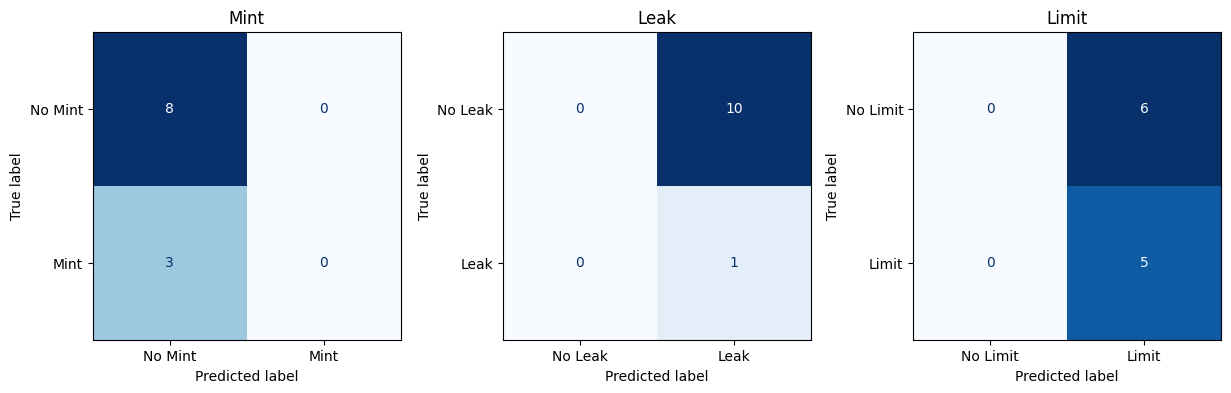

In [41]:
# Model setup
tuned_txn_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_txn_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_txn_gcn_model.train()
for epoch in range(epochs):
    for batch in txn_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_txn_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_txn_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in txn_graph_test_loader:
        out = tuned_txn_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### Control Flow

##### Load Data

In [42]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [43]:
train_dataset, test_dataset = [], []
cfg_graph_y_train, cfg_graph_y_test = [], []
cfg_graph_test_idx = []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        cfg_graph_y_train.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        cfg_graph_y_test.append(y.loc[address])
        cfg_graph_test_idx.append(address)

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [44]:
len(train_dataset), len(test_dataset)

(47, 20)

In [45]:
cfg_graph_train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
cfg_graph_test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [46]:
epochs = 30

In [47]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in cfg_graph_train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in cfg_graph_test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 22:12:22,524] A new study created in memory with name: no-name-89851473-2e8f-4201-b74a-89198cd9aee5


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:12:25,363] Trial 0 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 41, 'lr': 1.942636416826418e-06, 'dropout': 0.20703327119029416}. Best is trial 0 with value: 0.1728395061728395.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:12:34,894] Trial 1 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 256, 'lr': 2.6769466413816383e-05, 'dropout': 0.5736187196207805}. Best is trial 0 with value: 0.1728395061728395.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:12:39,440] Trial 2 finished with value: 0.19943019943019943 and parameters: {'hidden_dim': 109, 'lr': 0.00029563003462892973, 'dropout': 0.42489433037355273}. Best is trial 2 with value: 0.19943019943019943.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:12:46,196] Trial 3 finished with value: 0.11779448621553884 and parameters: {'hidden_dim': 174, 'lr': 2.3892289803138377e-05, 'dropout': 0.1886675606453584}. Best is trial 2 with value: 0.19943019943019943.


Label 0: Best threshold = 0.01, Best f1 = 0.5555555555555556


[I 2025-07-28 22:12:54,707] Trial 4 finished with value: 0.4296296296296296 and parameters: {'hidden_dim': 221, 'lr': 1.0835013832324817e-05, 'dropout': 0.47433926693238865}. Best is trial 4 with value: 0.4296296296296296.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.01, Best f1 = 0.7333333333333333
Label 0: Best threshold = 0.01, Best f1 = 0.7777777777777778
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:12:59,906] Trial 5 finished with value: 0.4725925925925926 and parameters: {'hidden_dim': 146, 'lr': 0.00013818754759826782, 'dropout': 0.33457814143479275}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:04,965] Trial 6 finished with value: 0.2777777777777778 and parameters: {'hidden_dim': 122, 'lr': 5.9949794499905805e-05, 'dropout': 0.1764659470361588}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:09,766] Trial 7 finished with value: 0.32952380952380955 and parameters: {'hidden_dim': 120, 'lr': 0.0014871015472188542, 'dropout': 0.3797500542059723}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:16,597] Trial 8 finished with value: 0.3386243386243386 and parameters: {'hidden_dim': 187, 'lr': 0.0002834101093116513, 'dropout': 0.3512541400839442}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:24,047] Trial 9 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 194, 'lr': 1.0059722538645332e-05, 'dropout': 0.10088991274704258}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:27,389] Trial 10 finished with value: 0.17777777777777778 and parameters: {'hidden_dim': 68, 'lr': 0.005817084361925179, 'dropout': 0.6548864153383354}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5217391304347826
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:13:36,955] Trial 11 finished with value: 0.45213884992987374 and parameters: {'hidden_dim': 246, 'lr': 2.7190661840534915e-06, 'dropout': 0.5098330045098903}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:13:46,893] Trial 12 finished with value: 0.4202931571352624 and parameters: {'hidden_dim': 251, 'lr': 1.204318750148039e-06, 'dropout': 0.7437239364727399}. Best is trial 5 with value: 0.4725925925925926.


Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.6
Label 1: Best threshold = 0.01, Best f1 = 0.42105263157894735


[I 2025-07-28 22:13:52,360] Trial 13 finished with value: 0.34035087719298246 and parameters: {'hidden_dim': 149, 'lr': 0.00026061378298605916, 'dropout': 0.5117104731417076}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:14:00,890] Trial 14 finished with value: 0.3148148148148148 and parameters: {'hidden_dim': 220, 'lr': 4.088512402579906e-06, 'dropout': 0.29351974428963706}. Best is trial 5 with value: 0.4725925925925926.


Label 1: Best threshold = 0.01, Best f1 = 0.5
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:04,776] Trial 15 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 84, 'lr': 0.0013949658787749458, 'dropout': 0.5869004281595369}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:14:10,857] Trial 16 finished with value: 0.3841215574548908 and parameters: {'hidden_dim': 152, 'lr': 9.920883880734612e-05, 'dropout': 0.2997374759658198}. Best is trial 5 with value: 0.4725925925925926.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:18,737] Trial 17 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 220, 'lr': 4.548238410294297e-06, 'dropout': 0.7808063656423094}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:14:21,972] Trial 18 finished with value: 0.29545454545454547 and parameters: {'hidden_dim': 32, 'lr': 0.0007841929006773737, 'dropout': 0.07271410518700017}. Best is trial 5 with value: 0.4725925925925926.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:28,258] Trial 19 finished with value: 0.30952380952380953 and parameters: {'hidden_dim': 171, 'lr': 4.134612256287365e-05, 'dropout': 0.012143699891007831}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5333333333333333
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:32,150] Trial 20 finished with value: 0.3259259259259259 and parameters: {'hidden_dim': 84, 'lr': 0.008124735246437007, 'dropout': 0.6811221439439483}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:40,255] Trial 21 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 212, 'lr': 7.96147573133326e-06, 'dropout': 0.4454372168311842}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:49,539] Trial 22 finished with value: 0.2810035842293907 and parameters: {'hidden_dim': 236, 'lr': 1.1261328207261791e-05, 'dropout': 0.49700159251155657}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:14:57,271] Trial 23 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 202, 'lr': 1.8158774474661338e-06, 'dropout': 0.49019479930197796}. Best is trial 5 with value: 0.4725925925925926.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:15:06,727] Trial 24 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 235, 'lr': 3.1987492369264057e-06, 'dropout': 0.5738523039733193}. Best is trial 24 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-28 22:15:16,207] Trial 25 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 242, 'lr': 3.431115956384553e-06, 'dropout': 0.5563340161654313}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:15:25,663] Trial 26 finished with value: 0.4027245636441039 and parameters: {'hidden_dim': 232, 'lr': 0.00011236083269599954, 'dropout': 0.6272502571892752}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.46153846153846156
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:15:32,037] Trial 27 finished with value: 0.26495726495726496 and parameters: {'hidden_dim': 173, 'lr': 1.1807684565871909e-06, 'dropout': 0.3275878329801611}. Best is trial 24 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:15:37,979] Trial 28 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 135, 'lr': 1.9595335801147906e-05, 'dropout': 0.403429596126443}. Best is trial 24 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:15:41,041] Trial 29 finished with value: 0.047619047619047616 and parameters: {'hidden_dim': 53, 'lr': 3.320884681517898e-06, 'dropout': 0.2525861105217889}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-28 22:15:49,201] Trial 30 finished with value: 0.3006993006993007 and parameters: {'hidden_dim': 205, 'lr': 0.00012802401146762112, 'dropout': 0.7048186946073527}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:15:57,647] Trial 31 finished with value: 0.22923976608187133 and parameters: {'hidden_dim': 228, 'lr': 6.130114184052885e-06, 'dropout': 0.4817687614451334}. Best is trial 24 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:16:07,546] Trial 32 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 256, 'lr': 2.3583804719204437e-06, 'dropout': 0.5564152087480687}. Best is trial 24 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:17,031] Trial 33 finished with value: 0.0 and parameters: {'hidden_dim': 242, 'lr': 1.7034705868606732e-05, 'dropout': 0.4480153185784605}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:24,110] Trial 34 finished with value: 0.37414669571532316 and parameters: {'hidden_dim': 190, 'lr': 4.388124382211707e-05, 'dropout': 0.6190935299588817}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:33,006] Trial 35 finished with value: 0.21212121212121213 and parameters: {'hidden_dim': 219, 'lr': 2.3136784889733754e-06, 'dropout': 0.538595185050289}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:39,571] Trial 36 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 159, 'lr': 1.3567993993013479e-05, 'dropout': 0.23341172559703552}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:43,774] Trial 37 finished with value: 0.0 and parameters: {'hidden_dim': 97, 'lr': 2.951646852927498e-05, 'dropout': 0.3954571362513721}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:16:53,594] Trial 38 finished with value: 0.26666666666666666 and parameters: {'hidden_dim': 246, 'lr': 6.159756226471e-06, 'dropout': 0.35293725127697895}. Best is trial 24 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:16:58,670] Trial 39 finished with value: 0.0 and parameters: {'hidden_dim': 132, 'lr': 0.0005312796522075878, 'dropout': 0.4443384514883838}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:17:05,851] Trial 40 finished with value: 0.19576719576719573 and parameters: {'hidden_dim': 180, 'lr': 0.00017521944680652397, 'dropout': 0.5806429270520052}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:17:15,131] Trial 41 finished with value: 0.42610162344507696 and parameters: {'hidden_dim': 252, 'lr': 1.1740917342826227e-06, 'dropout': 0.7441352875168965}. Best is trial 24 with value: 0.5205097570688969.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:17:24,361] Trial 42 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 230, 'lr': 1.0639688791042185e-06, 'dropout': 0.7297662261792615}. Best is trial 24 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:17:34,845] Trial 43 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 254, 'lr': 1.8614510278933322e-06, 'dropout': 0.7779384036561566}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185


[I 2025-07-28 22:17:43,166] Trial 44 finished with value: 0.16 and parameters: {'hidden_dim': 210, 'lr': 6.95776898327904e-05, 'dropout': 0.66592660858992}. Best is trial 24 with value: 0.5205097570688969.


Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:17:52,062] Trial 45 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 239, 'lr': 1.5984623261784499e-06, 'dropout': 0.5163972770351585}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.7692307692307693
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:18:00,135] Trial 46 finished with value: 0.25641025641025644 and parameters: {'hidden_dim': 199, 'lr': 2.847402275231893e-06, 'dropout': 0.6199021186413115}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:18:09,365] Trial 47 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 223, 'lr': 7.45629839335144e-06, 'dropout': 0.34840128170728746}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:18:18,876] Trial 48 finished with value: 0.20350877192982456 and parameters: {'hidden_dim': 249, 'lr': 4.670335587296315e-06, 'dropout': 0.17210555604797675}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:18:23,587] Trial 49 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 104, 'lr': 1.4736802677154532e-06, 'dropout': 0.4149738577636041}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:18:31,645] Trial 50 finished with value: 0.3789173789173789 and parameters: {'hidden_dim': 216, 'lr': 0.0004352120357768629, 'dropout': 0.47109635882895184}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.5


[I 2025-07-28 22:18:41,423] Trial 51 finished with value: 0.514336917562724 and parameters: {'hidden_dim': 249, 'lr': 1.2724384613852384e-06, 'dropout': 0.7423861847578807}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173


[I 2025-07-28 22:18:51,193] Trial 52 finished with value: 0.11594202898550725 and parameters: {'hidden_dim': 256, 'lr': 2.5074778829683007e-06, 'dropout': 0.7044885588800048}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:00,404] Trial 53 finished with value: 0.0 and parameters: {'hidden_dim': 234, 'lr': 1.0140417575037795e-06, 'dropout': 0.7951594231854915}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:09,572] Trial 54 finished with value: 0.38285714285714284 and parameters: {'hidden_dim': 244, 'lr': 0.0035572140359812236, 'dropout': 0.7516190012111733}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.01, Best f1 = 0.72
Label 0: Best threshold = 0.01, Best f1 = 0.7692307692307693
Label 1: Best threshold = 0.01, Best f1 = 0.5


[I 2025-07-28 22:19:18,435] Trial 55 finished with value: 0.47863247863247865 and parameters: {'hidden_dim': 227, 'lr': 4.0409676828854055e-06, 'dropout': 0.6404706192328417}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:28,406] Trial 56 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 226, 'lr': 4.642443473036685e-06, 'dropout': 0.5938032676635225}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:37,471] Trial 57 finished with value: 0.377299880525687 and parameters: {'hidden_dim': 207, 'lr': 1.0346108609631665e-05, 'dropout': 0.543371946927329}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.36363636363636365


[I 2025-07-28 22:19:44,248] Trial 58 finished with value: 0.2940516273849607 and parameters: {'hidden_dim': 183, 'lr': 0.00021047019515990043, 'dropout': 0.6449683742006823}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:53,300] Trial 59 finished with value: 0.4109347442680776 and parameters: {'hidden_dim': 236, 'lr': 4.067215913297859e-06, 'dropout': 0.5193046612087635}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:19:59,531] Trial 60 finished with value: 0.3950617283950617 and parameters: {'hidden_dim': 163, 'lr': 7.437121402213417e-05, 'dropout': 0.5999784289486855}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:20:08,420] Trial 61 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 227, 'lr': 1.8090869109225569e-06, 'dropout': 0.6830090892495673}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:20:17,958] Trial 62 finished with value: 0.0 and parameters: {'hidden_dim': 248, 'lr': 1.4596198112471466e-06, 'dropout': 0.7664632619302875}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:20:27,298] Trial 63 finished with value: 0.297008547008547 and parameters: {'hidden_dim': 238, 'lr': 3.197004730964513e-06, 'dropout': 0.7236501562401508}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4


[I 2025-07-28 22:20:35,214] Trial 64 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 215, 'lr': 8.43603171506874e-06, 'dropout': 0.6469810464526032}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:20:43,017] Trial 65 finished with value: 0.19829059829059828 and parameters: {'hidden_dim': 197, 'lr': 6.036448840097384e-06, 'dropout': 0.6883663165197587}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:20:53,239] Trial 66 finished with value: 0.0 and parameters: {'hidden_dim': 249, 'lr': 1.3465600173430825e-06, 'dropout': 0.38223135062096153}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.375


[I 2025-07-28 22:21:01,897] Trial 67 finished with value: 0.2978395061728395 and parameters: {'hidden_dim': 223, 'lr': 2.1814044878773574e-06, 'dropout': 0.289045013046491}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:21:05,970] Trial 68 finished with value: 0.19607843137254902 and parameters: {'hidden_dim': 69, 'lr': 3.2053745441047642e-06, 'dropout': 0.4629628993772732}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.375


[I 2025-07-28 22:21:14,812] Trial 69 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 242, 'lr': 1.4191628735376374e-05, 'dropout': 0.5667060800803191}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.01, Best f1 = 0.5217391304347826
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:21:24,221] Trial 70 finished with value: 0.21557971014492752 and parameters: {'hidden_dim': 229, 'lr': 3.1750379329654756e-05, 'dropout': 0.7150248667090914}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:21:34,109] Trial 71 finished with value: 0.4093986459577857 and parameters: {'hidden_dim': 252, 'lr': 1.0370790540136322e-06, 'dropout': 0.7541661888221824}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:21:43,112] Trial 72 finished with value: 0.0 and parameters: {'hidden_dim': 234, 'lr': 2.164806473443746e-06, 'dropout': 0.7464210405596424}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:21:52,192] Trial 73 finished with value: 0.0 and parameters: {'hidden_dim': 256, 'lr': 1.2813252736516769e-06, 'dropout': 0.6591259969240209}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:01,862] Trial 74 finished with value: 0.31989247311827956 and parameters: {'hidden_dim': 246, 'lr': 4.10053581142742e-06, 'dropout': 0.7973314303155721}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:07,523] Trial 75 finished with value: 0.2839506172839506 and parameters: {'hidden_dim': 125, 'lr': 1.7936647426593443e-06, 'dropout': 0.736355143666913}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:16,263] Trial 76 finished with value: 0.3464387464387464 and parameters: {'hidden_dim': 242, 'lr': 2.680224711578963e-06, 'dropout': 0.5050035207422594}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:24,834] Trial 77 finished with value: 0.15277777777777776 and parameters: {'hidden_dim': 218, 'lr': 5.3608719415786865e-06, 'dropout': 0.5324982828723157}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.4444444444444444


[I 2025-07-28 22:22:34,289] Trial 78 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 234, 'lr': 0.00012818666270486147, 'dropout': 0.6229304056106394}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:44,843] Trial 79 finished with value: 0.43100358422939067 and parameters: {'hidden_dim': 251, 'lr': 1.3840584727345397e-06, 'dropout': 0.6960369512940516}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:52,762] Trial 80 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 191, 'lr': 7.4543620663603265e-06, 'dropout': 0.5999622181124139}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:22:58,892] Trial 81 finished with value: 0.0 and parameters: {'hidden_dim': 144, 'lr': 1.3200848687974866e-06, 'dropout': 0.6872215984108154}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:23:08,920] Trial 82 finished with value: 0.0 and parameters: {'hidden_dim': 249, 'lr': 1.9175310046826417e-06, 'dropout': 0.7077647585984824}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:23:17,949] Trial 83 finished with value: 0.0 and parameters: {'hidden_dim': 238, 'lr': 3.5887789482371295e-06, 'dropout': 0.4303543319320108}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:23:27,560] Trial 84 finished with value: 0.3395061728395062 and parameters: {'hidden_dim': 250, 'lr': 2.6572494226114685e-06, 'dropout': 0.7654770629989066}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:23:36,893] Trial 85 finished with value: 0.3106332138590203 and parameters: {'hidden_dim': 244, 'lr': 1.5066097534442989e-06, 'dropout': 0.678561217559135}. Best is trial 24 with value: 0.5205097570688969.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:23:45,001] Trial 86 finished with value: 0.5253406749432931 and parameters: {'hidden_dim': 230, 'lr': 1.1480289892497274e-06, 'dropout': 0.3171688538826907}. Best is trial 86 with value: 0.5253406749432931.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:23:52,941] Trial 87 finished with value: 0.0 and parameters: {'hidden_dim': 212, 'lr': 2.021377329391593e-06, 'dropout': 0.26521078219921784}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:01,757] Trial 88 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 230, 'lr': 1.1628131377189946e-06, 'dropout': 0.30914558405050324}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:09,771] Trial 89 finished with value: 0.21728395061728392 and parameters: {'hidden_dim': 223, 'lr': 4.501803106429198e-05, 'dropout': 0.3621560720457955}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:18,729] Trial 90 finished with value: 0.13095238095238096 and parameters: {'hidden_dim': 240, 'lr': 0.000328871727947232, 'dropout': 0.5630403524421513}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:28,615] Trial 91 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 251, 'lr': 1.5109770853628412e-06, 'dropout': 0.32611080773828294}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:37,135] Trial 92 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 232, 'lr': 1.1043865855940931e-06, 'dropout': 0.782177956332864}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.34782608695652173


[I 2025-07-28 22:24:46,194] Trial 93 finished with value: 0.5253406749432931 and parameters: {'hidden_dim': 256, 'lr': 1.0054094594385283e-06, 'dropout': 0.6396574867059499}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:24:56,670] Trial 94 finished with value: 0.21212121212121213 and parameters: {'hidden_dim': 254, 'lr': 1.0002374320924899e-06, 'dropout': 0.6112463473294306}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


[I 2025-07-28 22:25:06,546] Trial 95 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 244, 'lr': 2.519748912012952e-06, 'dropout': 0.5768388554790669}. Best is trial 86 with value: 0.5253406749432931.


Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:25:15,351] Trial 96 finished with value: 0.3094606542882405 and parameters: {'hidden_dim': 225, 'lr': 0.00015954629241787254, 'dropout': 0.6394389621113749}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:25:19,960] Trial 97 finished with value: 0.3808086524555116 and parameters: {'hidden_dim': 115, 'lr': 1.7429368987305362e-06, 'dropout': 0.6637847027002403}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.01, Best f1 = 0.38095238095238093


[I 2025-07-28 22:25:29,237] Trial 98 finished with value: 0.3635432667690732 and parameters: {'hidden_dim': 238, 'lr': 3.6398756267442167e-06, 'dropout': 0.27470619492887904}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333


[I 2025-07-28 22:25:33,049] Trial 99 finished with value: 0.3055555555555555 and parameters: {'hidden_dim': 85, 'lr': 3.0085795733362566e-06, 'dropout': 0.22249512588422343}. Best is trial 86 with value: 0.5253406749432931.


Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
Best Params: {'hidden_dim': 230, 'lr': 1.1480289892497274e-06, 'dropout': 0.3171688538826907}
Best Score: 0.5253406749432931


##### Final

Label 0: Best threshold = 0.0, Best f1 = 0.5185185185185185
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00         7
        Leak       0.12      0.25      0.17         4
       Limit       0.00      0.00      0.00        11

   micro avg       0.12      0.05      0.07        22
   macro avg       0.04      0.08      0.06        22
weighted avg       0.02      0.05      0.03        22
 samples avg       0.05      0.02      0.03        22



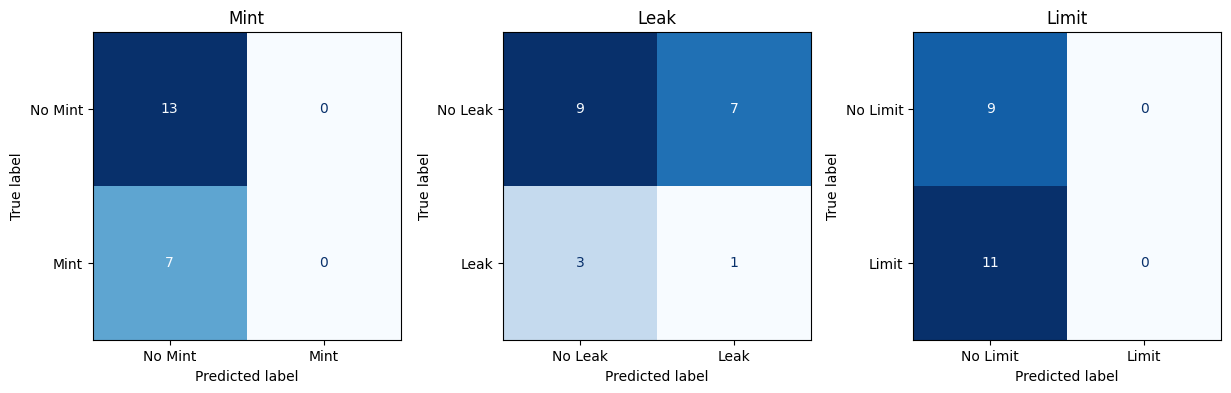

In [48]:
# Model setup
tuned_cfg_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_cfg_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_cfg_gcn_model.train()
for epoch in range(epochs):
    for batch in cfg_graph_train_loader:
        optimizer.zero_grad()
        out = tuned_cfg_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_cfg_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in cfg_graph_test_loader:
        out = tuned_cfg_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

## Fusion

### Track Which Model Can Predict Which Address

In [95]:
def predict(model, loader, thresholds=None):
    model.eval()
    y_true, y_probs, y_preds = [], [], []

    with torch.no_grad():
        for batch in loader:
            out = torch.sigmoid(model(batch))
            y_probs.append(out.cpu())
            y_true.append(batch.y.cpu())

    y_probs = torch.cat(y_probs).numpy()
    y_true = torch.cat(y_true).numpy()

    if thresholds is not None:
        y_preds = (y_probs > thresholds).astype(int)
    else:
        best_thresholds, _ = tune_thresholds(y_true, y_probs)
        y_preds = (y_probs > best_thresholds).astype(int)

    return y_true, y_preds, y_probs

In [96]:
# For each model, create a dict of predictions and a set of supported addresses
available_preds = {}
available_y_true = {}
B_weights = {}
C_weights = {}

for model_name, model_obj, test_idx, X_test, y_test in [
    ("txn", tuned_txn_model, txn_test_idx, txn_X_test, txn_y_test),
    ("byte", tuned_byte_model, byte_test_idx, byte_X_test, byte_y_test),
    ("source", tuned_source_model, source_test_idx, source_X_test, source_y_test),
    ("timeseries", tuned_gru_model, ts_test_idx, ts_X_test, ts_y_test),
    ("txn_gcn", tuned_txn_gcn_model, txn_graph_test_idx, txn_graph_test_loader, txn_graph_y_test),
    ("cfg_gcn", tuned_cfg_gcn_model, cfg_graph_test_idx, cfg_graph_test_loader, cfg_graph_y_test)
]:
    print(f"Predicting {model_name}...")
    if model_name in ['txn_gcn', 'cfg_gcn']:
        _, y_pred, _ = predict(model_obj, X_test)
    else:
        y_pred = model_obj.predict(X_test)

        if model_name == 'timeseries':
            thresholds, _ = tune_thresholds(y_test, y_pred)
            y_pred = (y_pred > thresholds).astype(int)

    available_preds[model_name] = {addr: pred for addr, pred in zip(test_idx, y_pred)}
    y_test = np.array(y_test)
    available_y_true[model_name] = {addr: y for addr, y in zip(test_idx, y_test)}
    # avg weights
    B_weights[model_name] = f1_score(y_test, y_pred, average='macro')
    # per-lab weights
    C_weights[model_name] = f1_score(y_test, y_pred, average=None)

Predicting txn...
Predicting byte...
Predicting source...
Predicting timeseries...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Label 0: Best threshold = 0.18, Best f1 = 0.7619047619047619
Label 1: Best threshold = 0.07, Best f1 = 0.4444444444444444
Label 2: Best threshold = 0.23, Best f1 = 0.8461538461538461
Predicting txn_gcn...
Label 0: Best threshold = 0.0, Best f1 = 0.42857142857142855
Label 1: Best threshold = 0.0, Best f1 = 0.16666666666666666
Label 2: Best threshold = 0.53, Best f1 = 0.6666666666666666
Predicting cfg_gcn...
Label 0: Best threshold = 0.01, Best f1 = 0.5263157894736842
Label 1: Best threshold = 0.0, Best f1 = 0.3333333333333333
Label 2: Best threshold = 0.0, Best f1 = 0.7096774193548387


In [97]:
B_weights

{'txn': 0.4488152749022314,
 'byte': 0.6126984126984127,
 'source': 0.6295739348370927,
 'timeseries': 0.6841676841676841,
 'txn_gcn': 0.4444444444444444,
 'cfg_gcn': 0.5231088473872855}

In [98]:
C_weights

{'txn': array([0.22222222, 0.42857143, 0.69565217]),
 'byte': array([0.57142857, 0.66666667, 0.6       ]),
 'source': array([0.85714286, 0.4       , 0.63157895]),
 'timeseries': array([0.76190476, 0.44444444, 0.84615385]),
 'txn_gcn': array([0.5       , 0.16666667, 0.66666667]),
 'cfg_gcn': array([0.52631579, 0.33333333, 0.70967742])}

In [99]:
available_preds_df = pd.DataFrame(available_preds)
available_preds_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 1, 1]","[1, 1, 1]","[1, 1, 1]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[0, 1, 1]","[0, 0, 0]",NaN,"[1, 1, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 1, 0]","[1, 1, 0]","[1, 1, 1]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[0, 0, 0]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 1, 1]","[0, 1, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 1, 1]","[1, 1, 1]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[0, 1, 1]","[1, 0, 0]","[1, 0, 0]","[1, 1, 1]",NaN,"[1, 1, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 1, 1]","[0, 0, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[0, 1, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 0]","[0, 0, 1]","[1, 1, 1]",NaN,"[0, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 1, 0]","[1, 1, 1]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[1, 1, 1]","[0, 0, 1]","[1, 1, 1]",NaN,"[0, 1, 1]"


In [100]:
available_y_true_df = pd.DataFrame(available_y_true)
available_y_true_df

,txn,byte,source,timeseries,txn_gcn,cfg_gcn
0x186ed770eecea82def7c92dcc077c4ba27acd5bd,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0x93023f1d3525e273f291b6f76d2f5027a39bf302,"[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]",NaN,NaN
0x16dfb898cf7029303c2376031392cb9bac450f94,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]"
0xb504035a11e672e12a099f32b1672b9c4a78b22f,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x52e4339b4b9ff254738d6e971e83440f60dc029c,"[1, 0, 1]","[1, 0, 1]","[1, 0, 1]","[1, 0, 1]",NaN,"[1, 0, 1]"
0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc,"[0, 0, 1]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1]",NaN,"[0, 0, 1]"
0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"
0xaaf8c293ed36989d1871d2310b2845450d885673,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
0x1e4402fa427a7a835fc64ea6d051404ce767a569,"[0, 1, 1]","[0, 1, 1]","[0, 1, 1]","[0, 1, 1]",NaN,"[0, 1, 1]"


### Option A: Majority Voting

In [101]:
from collections import defaultdict, Counter

A_final_preds = {}
for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    label_votes = []
    for model_name, preds in available_preds.items():
        if addr in preds:
            label_votes.append(preds[addr])

    # Majority vote across models
    if label_votes:
        # Convert to array and round mean for voting
        fused = np.round(np.mean(label_votes, axis=0)).astype(int)
        A_final_preds[addr] = fused


In [102]:
A_final_preds['0x186ed770eecea82def7c92dcc077c4ba27acd5bd'], A_final_preds['0x93023f1d3525e273f291b6f76d2f5027a39bf302']

(array([1, 0, 0]), array([0, 1, 1]))

              precision    recall  f1-score   support

        Mint       1.00      0.75      0.86         8
        Leak       0.30      0.75      0.43         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.64      0.75      0.69        24
   macro avg       0.68      0.75      0.68        24
weighted avg       0.76      0.75      0.73        24
 samples avg       0.42      0.52      0.44        24



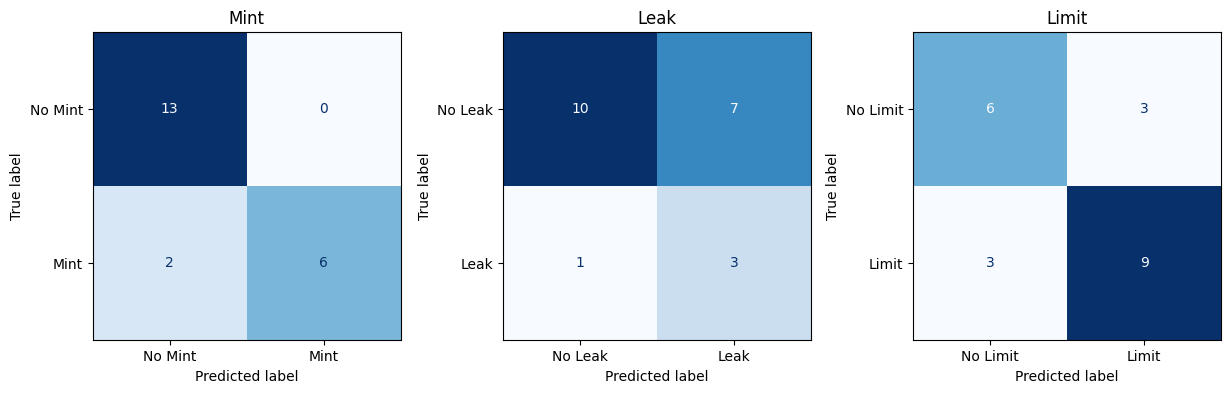

In [103]:
# Build y_true and y_pred from common addresses
common_addrs = list(A_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([A_final_preds[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)

### Option B: Weighted Averaging

In [154]:
def objective(trial):
    thresholds = np.array([
        trial.suggest_float(f"thresh_{label}", 0.3, 0.9)
        for label in label_cols
    ])

    y_pred = (y_probs > thresholds).astype(int)
    score = f1_score(y_true, y_pred, average='macro')
    return score


In [155]:
B_final_preds = {}
B_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = 0

    for model_name, preds in available_preds.items():
        if addr in preds:
            weighted_sum += B_weights[model_name] * preds[addr]
            total_weight += B_weights[model_name]

    fused_probs = weighted_sum / total_weight
    fused = fused_probs > 0.6
    B_probs[addr] = fused_probs
    B_final_preds[addr] = fused.astype(int)


              precision    recall  f1-score   support

        Mint       1.00      0.75      0.86         8
        Leak       0.75      0.75      0.75         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.84      0.67      0.74        24
   macro avg       0.84      0.69      0.76        24
weighted avg       0.85      0.67      0.74        24
 samples avg       0.52      0.48      0.49        24



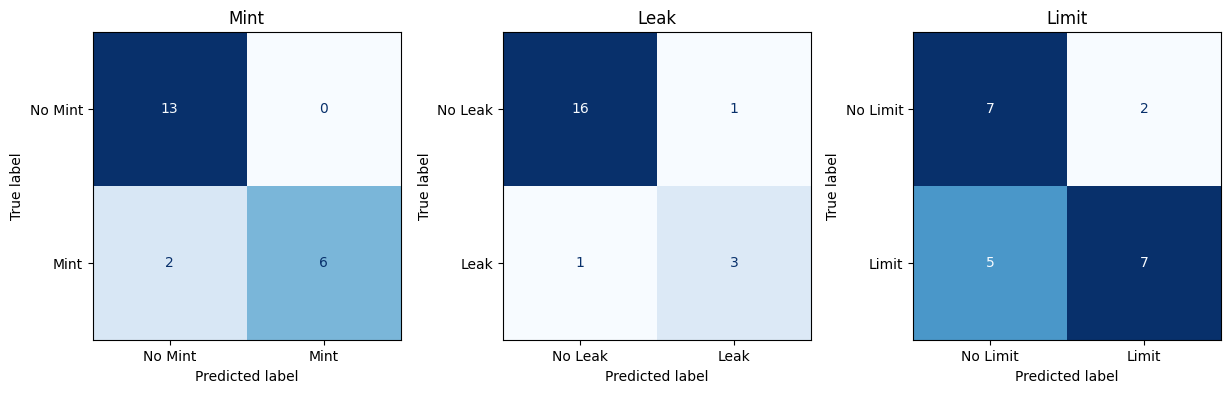

In [156]:
# Build y_true and y_pred from common addresses
common_addrs = list(B_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([B_final_preds[addr] for addr in common_addrs])
y_probs = np.array([B_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [157]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-28 23:44:37,638] A new study created in memory with name: no-name-29bbb3e2-7e33-45d0-b4ce-6099ba558d12
[I 2025-07-28 23:44:37,645] Trial 0 finished with value: 0.7968253968253968 and parameters: {'thresh_Mint': 0.5124128394724005, 'thresh_Leak': 0.6863808396172955, 'thresh_Limit': 0.7590498178221476}. Best is trial 0 with value: 0.7968253968253968.
[I 2025-07-28 23:44:37,652] Trial 1 finished with value: 0.628849902534113 and parameters: {'thresh_Mint': 0.31958210854238833, 'thresh_Leak': 0.3483139972931457, 'thresh_Limit': 0.6837764048873316}. Best is trial 0 with value: 0.7968253968253968.
[I 2025-07-28 23:44:37,657] Trial 2 finished with value: 0.8164160401002506 and parameters: {'thresh_Mint': 0.32051122853263236, 'thresh_Leak': 0.7362540248190192, 'thresh_Limit': 0.570915168354079}. Best is trial 2 with value: 0.8164160401002506.
[I 2025-07-28 23:44:37,665] Trial 3 finished with value: 0.6613756613756613 and parameters: {'thresh_Mint': 0.6748305157075476, 'thresh_Leak':

Best Thresholds: [0.50269634 0.72842641 0.31051103]


              precision    recall  f1-score   support

        Mint       1.00      0.88      0.93         8
        Leak       1.00      0.75      0.86         4
       Limit       0.80      1.00      0.89        12

   micro avg       0.88      0.92      0.90        24
   macro avg       0.93      0.88      0.89        24
weighted avg       0.90      0.92      0.90        24
 samples avg       0.62      0.62      0.60        24



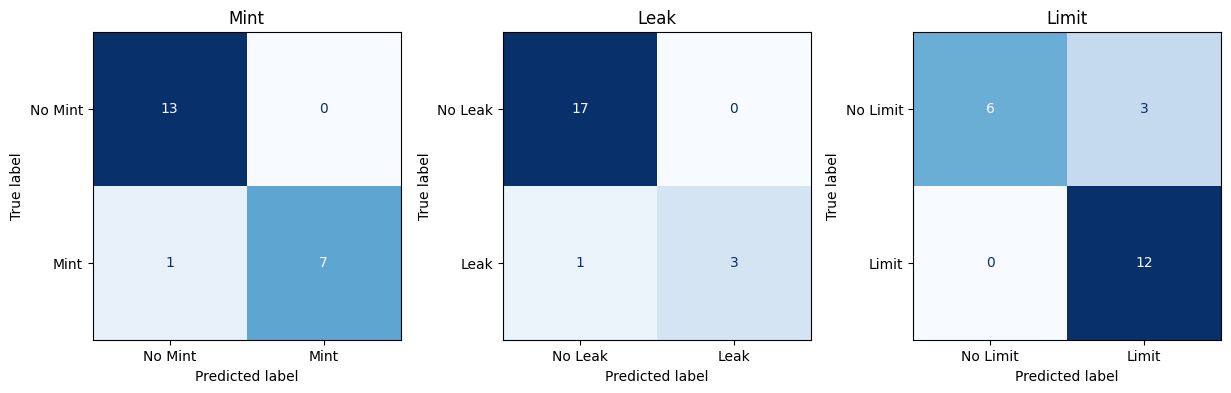

In [158]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

### Option C: Per-label weight

In [159]:
C_final_preds = {}
C_probs = {}

for addr in set.union(*[set(preds.keys()) for preds in available_preds.values()]):
    weighted_sum = np.zeros(len(label_cols))
    total_weight = np.zeros(len(label_cols))  # per-label weights

    for model_name, preds in available_preds.items():
        if addr in preds:
            model_weights = np.array(C_weights[model_name])
            prediction = np.array(preds[addr])

            weighted_sum += model_weights * prediction
            total_weight += model_weights

    fused_probs = (weighted_sum / np.maximum(total_weight, 1e-8))
    fused = fused_probs > 0.6
    C_probs[addr] = fused_probs
    C_final_preds[addr] = fused.astype(int)

              precision    recall  f1-score   support

        Mint       1.00      0.75      0.86         8
        Leak       1.00      0.75      0.86         4
       Limit       0.75      0.75      0.75        12

   micro avg       0.86      0.75      0.80        24
   macro avg       0.92      0.75      0.82        24
weighted avg       0.88      0.75      0.80        24
 samples avg       0.52      0.52      0.51        24



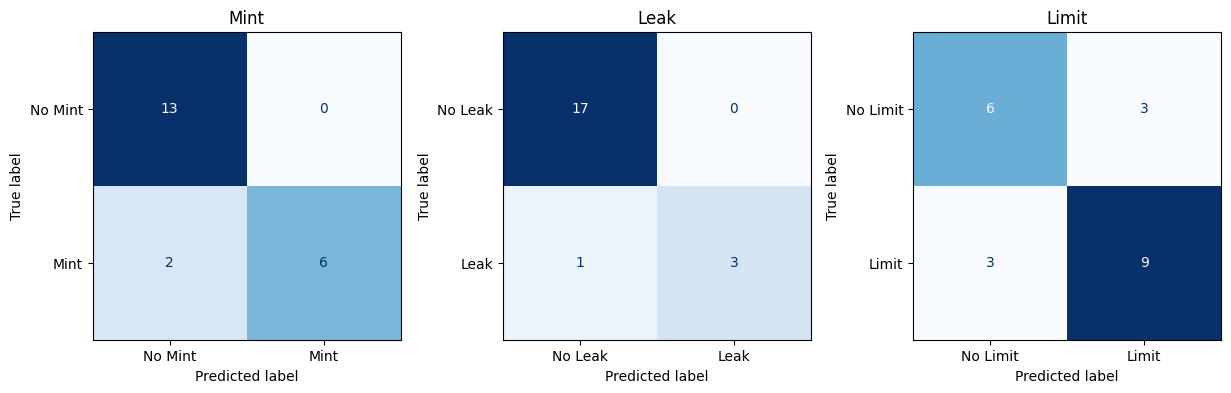

In [160]:
# Build y_true and y_pred from common addresses
common_addrs = list(C_final_preds.keys())
y_true = np.array([y.loc[addr].values for addr in common_addrs])
y_pred = np.array([C_final_preds[addr] for addr in common_addrs])
y_probs = np.array([C_probs[addr] for addr in common_addrs])

plot_confusion_matrix(y_true, y_pred)


In [161]:
C_final_preds

{'0x93023f1d3525e273f291b6f76d2f5027a39bf302': array([0, 0, 1]),
 '0x52e4339b4b9ff254738d6e971e83440f60dc029c': array([1, 0, 1]),
 '0x82902c20c5826984588dcd2dfcc322e05dcc435c': array([0, 0, 1]),
 '0x8b2e68075a06959e3e35aa0e451a13e099e41b23': array([1, 0, 1]),
 '0x292f57c7fcd726ba651e46b620d99cc6afe0ec1c': array([0, 0, 0]),
 '0x6609f543d38816116fa5b9a98c918ca947f5455d': array([0, 0, 0]),
 '0xaaf8c293ed36989d1871d2310b2845450d885673': array([0, 0, 0]),
 '0x10f6f2b97f3ab29583d9d38babf2994df7220c21': array([1, 0, 1]),
 '0xd217dc0cab1c952a7ce6f4d7ca4549cde1f37bb0': array([1, 0, 0]),
 '0x186ed770eecea82def7c92dcc077c4ba27acd5bd': array([0, 0, 0]),
 '0x8d07f605926837ea0f9e1e24dba0fb348cb3e97d': array([0, 1, 1]),
 '0xb504035a11e672e12a099f32b1672b9c4a78b22f': array([0, 0, 0]),
 '0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a': array([1, 0, 1]),
 '0x5927b72440d8a8b8c6ca5a8be60e88975f9063fc': array([0, 0, 1]),
 '0xc71d244f7ad6c869ecbf13cbd9acae31718be4f8': array([0, 0, 1]),
 '0x11cbc781dadaad13fc3a3

In [162]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_thresholds = np.array([study.best_params[f"thresh_{label}"] for label in label_cols])
print("Best Thresholds:", best_thresholds)

[I 2025-07-28 23:45:12,404] A new study created in memory with name: no-name-5b6c8fa5-e557-41a0-b0f1-59f13f88da63
[I 2025-07-28 23:45:12,410] Trial 0 finished with value: 0.5862068965517241 and parameters: {'thresh_Mint': 0.4574268512468062, 'thresh_Leak': 0.890851807283354, 'thresh_Limit': 0.32970262479093787}. Best is trial 0 with value: 0.5862068965517241.
[I 2025-07-28 23:45:12,416] Trial 1 finished with value: 0.6618736383442266 and parameters: {'thresh_Mint': 0.4533580547938689, 'thresh_Leak': 0.32154162596187963, 'thresh_Limit': 0.7601888854741872}. Best is trial 1 with value: 0.6618736383442266.
[I 2025-07-28 23:45:12,421] Trial 2 finished with value: 0.5746753246753247 and parameters: {'thresh_Mint': 0.8164927868049536, 'thresh_Leak': 0.40341326896860863, 'thresh_Limit': 0.562231757788066}. Best is trial 1 with value: 0.6618736383442266.
[I 2025-07-28 23:45:12,426] Trial 3 finished with value: 0.64578111946533 and parameters: {'thresh_Mint': 0.3987357880652493, 'thresh_Leak': 

Best Thresholds: [0.47912628 0.5756796  0.34209141]


              precision    recall  f1-score   support

        Mint       1.00      1.00      1.00         8
        Leak       1.00      0.75      0.86         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.88      0.92      0.90        24
   macro avg       0.93      0.89      0.90        24
weighted avg       0.89      0.92      0.90        24
 samples avg       0.57      0.62      0.59        24



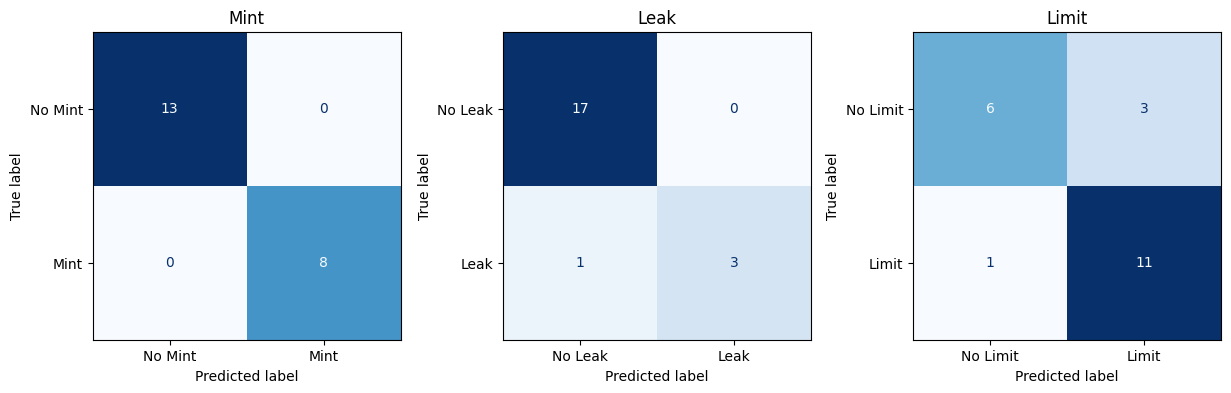

In [163]:
y_pred = (y_probs > best_thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)